# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD001 = pd.read_table("./CMAPSSData/train_FD001.txt", header=None, delim_whitespace=True)
train_FD001.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD001 = pd.read_table("./CMAPSSData/test_FD001.txt", header=None, delim_whitespace=True)
test_FD001.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD001 = pd.read_table("./CMAPSSData/RUL_FD001.txt", header=None, delim_whitespace=True)

In [3]:
train_FD001.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


# Feature extention

## Difference with previous row

In [4]:
train_FD001 = train_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [5]:
test_FD001 = test_FD001.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [6]:
# _id =1
# s2_diff = []
# s2_diff_temp = []
# diff_periods = 40
# for _id in set(train_FD001[id]):
#     trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
#     s2 = pd.Series(trainFD001_of_one_id['s2'])
#     for i in range(diff_periods):
#         s2_diff.append(s2.iloc[i]-s2.iloc[0])
#     s2_diff_temp=s2.diff(periods=diff_periods)
#     for j in range (len(s2)-diff_periods):
#         s2_diff.append(s2_diff_temp.iloc[diff_periods])


In [7]:
def cal_diff(df, sensor_name,diff_periods = 40):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD001_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD001_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [8]:
#from Feature_extention import cal_diff

In [9]:
#get all the names of sensors
list(train_FD001.columns)
sensor_name = list(train_FD001.columns)
sensor_name = sensor_name[2:16]
sensor_name

['s2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [10]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD001,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD001[name] = diff

In [11]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD001,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD001[name] = diff

In [12]:
test_FD001

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,...,-0.03,4.25,0.30,0.44,0.03,14.07,-0.0249,1.0,0.16,0.0181
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,...,0.01,6.79,0.30,0.25,0.00,4.55,0.0389,1.0,0.22,0.0431
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,...,-0.01,-4.88,0.08,-0.34,0.02,7.35,-0.0135,-1.0,0.14,0.0002
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,...,-0.03,-5.62,0.11,0.43,0.00,3.99,-0.0021,-2.0,0.13,0.0395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,...,-0.04,57.78,0.28,-1.07,-0.01,51.07,0.0547,1.0,-0.06,-0.1712
13092,100,195,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,...,0.04,55.23,-0.15,-0.48,0.03,47.77,0.0168,2.0,-0.33,-0.0866
13093,100,196,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,...,0.10,63.55,0.34,-0.37,0.03,56.06,0.0490,2.0,-0.36,-0.1970
13094,100,197,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,...,0.00,62.63,0.22,-0.54,0.04,50.81,0.0483,1.0,-0.29,-0.0711


In [13]:
train_FD001.describe()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,...,0.023402,5.561257,0.111194,-0.287735,0.024016,3.843622,0.013895,0.583345,-0.067852,-0.041126
std,29.227633,68.880990,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,...,0.051944,14.199764,0.184739,0.531359,0.052308,11.993591,0.032128,1.464765,0.157867,0.093940
min,1.000000,1.000000,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,...,-0.160000,-25.080000,-0.570000,-2.780000,-0.170000,-26.230000,-0.111000,-5.000000,-0.780000,-0.458700
25%,26.000000,52.000000,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,...,-0.010000,-2.210000,-0.020000,-0.610000,-0.010000,-2.440000,-0.007900,0.000000,-0.170000,-0.103100
50%,52.000000,104.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,...,0.020000,2.650000,0.100000,-0.260000,0.020000,1.490000,0.012700,1.000000,-0.060000,-0.038800
75%,77.000000,156.000000,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,...,0.050000,8.750000,0.230000,0.070000,0.060000,6.360000,0.035000,2.000000,0.040000,0.022850
max,100.000000,362.000000,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,...,0.520000,128.020000,0.920000,1.630000,0.560000,105.520000,0.153000,7.000000,0.540000,0.323300


## standard normalization 

In [14]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD001.iloc[:, 2:].mean()
std = train_FD001.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD001.iloc[:, 2:] = (train_FD001.iloc[:, 2:] - mean) / std

# Testing
test_FD001.iloc[:, 2:] = (test_FD001.iloc[:, 2:] - mean) / std

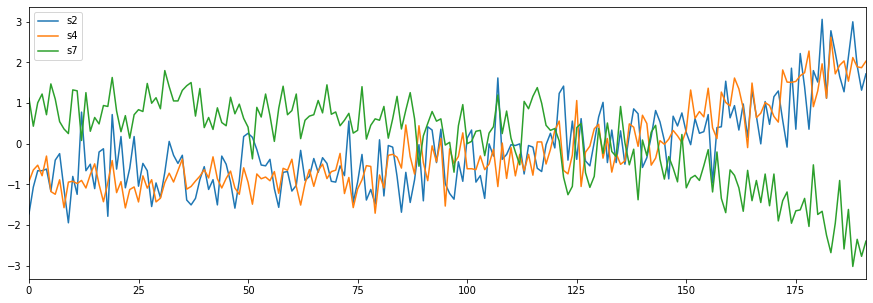

In [15]:
train_FD001[train_FD001["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [16]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 125
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD001[id]):
    trainFD001_of_one_id =  train_FD001[train_FD001[id] == _id]
    cycle_list = trainFD001_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD001["RUL"] = rul


### Testing

In [17]:
id='engine_id'
rul = []
for _id_test in set(test_FD001[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD001.iloc[_id_test - 1])
    testFD001_of_one_id =  test_FD001[test_FD001[id] == _id_test]
    cycle_list = testFD001_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD001["RUL"] = rul

In [18]:
min_shape = np.min([i[0] for i in train_FD001.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 128


In [19]:
min_shape = np.min([i[0] for i in test_FD001.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 31


In [20]:
train_FD001[train_FD001["engine_id"]==1].head()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,...,-0.391644,-0.601898,0.541508,-0.459126,-0.320473,-0.432480,-0.398252,0.429804,0.437793,125
1,1,2,-1.061754,0.211523,-0.643710,0.431920,-0.798074,-0.958794,-0.191578,1.174871,...,-0.540943,-0.493638,1.708328,0.496757,-0.914957,-0.049637,-0.398252,0.049737,0.486760,125
2,1,3,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,-0.557126,-1.015279,1.364688,...,0.083716,-1.684505,1.971804,-0.267949,-0.769880,-0.485393,-1.763658,-0.266986,-0.358456,125
3,1,4,-0.661797,-1.261284,-0.784812,1.222798,0.188044,-0.713808,-1.539452,1.961255,...,-0.159950,-2.442329,2.799870,0.687933,-0.719853,-2.029216,-0.398252,-0.710398,-0.042298,125
4,1,5,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,-0.457048,-0.977838,1.052846,...,0.239352,-1.630374,1.538951,-0.076773,-0.722354,-0.124338,0.284451,-0.583709,0.282376,125


### 去掉不变的sensor的值和setting

In [21]:
train_FD001

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-1.721684,-0.134252,-0.925914,1.121113,-0.516326,-0.862792,-0.266460,0.334254,...,-0.391644,-0.601898,0.541508,-0.459126,-0.320473,-0.432480,-0.398252,0.429804,0.437793,125
1,1,2,-1.061754,0.211523,-0.643710,0.431920,-0.798074,-0.958794,-0.191578,1.174871,...,-0.540943,-0.493638,1.708328,0.496757,-0.914957,-0.049637,-0.398252,0.049737,0.486760,125
2,1,3,-0.661797,-0.413156,-0.525940,1.008131,-0.234578,-0.557126,-1.015279,1.364688,...,0.083716,-1.684505,1.971804,-0.267949,-0.769880,-0.485393,-1.763658,-0.266986,-0.358456,125
3,1,4,-0.661797,-1.261284,-0.784812,1.222798,0.188044,-0.713808,-1.539452,1.961255,...,-0.159950,-2.442329,2.799870,0.687933,-0.719853,-2.029216,-0.398252,-0.710398,-0.042298,125
4,1,5,-0.621801,-1.251498,-0.301511,0.714376,-0.516326,-0.457048,-0.977838,1.052846,...,0.239352,-1.630374,1.538951,-0.076773,-0.722354,-0.124338,0.284451,-0.583709,0.282376,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,1.617961,1.216229,2.188322,-2.189276,1.315035,0.012546,1.979996,-2.607906,...,-0.184599,0.859620,-1.246362,1.834993,-0.068672,0.152679,3.015264,0.049737,-1.993535,4
20627,100,197,1.717950,2.279651,2.738285,-2.833277,1.878530,-0.006020,1.867673,-2.350298,...,-0.681790,0.588969,-2.582559,1.070287,-1.023348,1.920606,0.284451,-1.787256,-0.275425,3
20628,100,198,1.477975,1.946924,2.138325,-2.742891,2.019404,0.029754,2.054877,-1.902872,...,-0.562070,-0.006465,-0.700591,1.261463,-1.123402,2.860595,1.649858,-1.913945,-2.154275,2
20629,100,199,1.098016,2.403608,1.955004,-3.036645,2.160278,0.383875,3.178105,-2.363856,...,0.068222,2.970703,-1.265181,0.305580,-0.061168,2.502652,0.967155,-1.470533,-2.272435,1


### plot a figure

training (20631, 28) (20631,)
testing (13096, 28) (13096,)


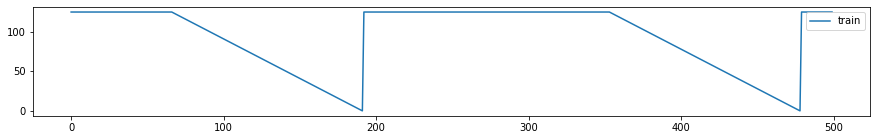

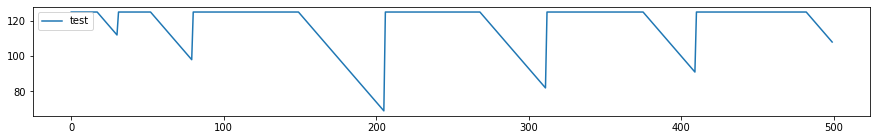

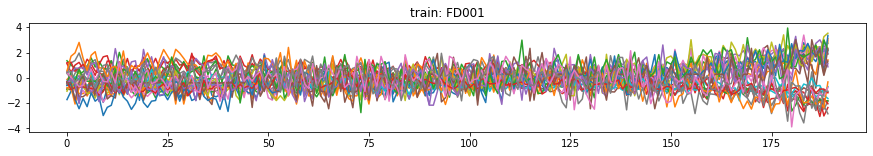

In [22]:
training_data = train_FD001.values
testing_data = test_FD001.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [23]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils


In [26]:
sequence_length=5
window_size = 24
kernel_size = 3

In [27]:
x_batch, y_batch =batch_generator(train_FD001,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [28]:
y_batch

array([[[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       [[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       [[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       ...,

       [[  6.],
        [  5.],
        [  4.],
        [  3.],
        [  2.]],

       [[  5.],
        [  4.],
        [  3.],
        [  2.],
        [  1.]],

       [[  4.],
        [  3.],
        [  2.],
        [  1.],
        [  0.]]], dtype=float32)

In [29]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [30]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 28),input_shape=(None, window_size, 28, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [31]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D_2 (None, None, 20, 1, 10)   39700     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_1 (ConvLSTM2D (None, None, 16, 1, 20)   18080     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16, 1, 20)   80        
_________________________________________________________________
time_distributed (TimeDistri (None, None, 320)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 320)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         3

In [32]:
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05)

Train on 17034 samples, validate on 897 samples
Epoch 1/30
17034/17034 [==============================] - 48s 3ms/sample - loss: 603.0962 - val_loss: 231.1015
Epoch 2/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 198.8471 - val_loss: 182.0802
Epoch 3/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 154.0752 - val_loss: 180.4483
Epoch 4/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 124.4282 - val_loss: 151.6367
Epoch 5/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 99.7250 - val_loss: 158.7619
Epoch 6/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 82.6698 - val_loss: 158.0916
Epoch 7/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 71.1029 - val_loss: 164.2070
Epoch 8/30
17034/17034 [==============================] - 42s 2ms/sample - loss: 61.9524 - val_loss: 173.0393
Epoch 9/30
17034/17034 [==============================] - 41s 2ms/sa

# Evaluation

## Tranining Performance

In [33]:
y_batch_pred = model.predict(x_batch)

In [34]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

3.8405044

## Test Performance

## Evaluation Method 1

In [35]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [36]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD001, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [37]:
y_batch_pred_test = model.predict(x_batch_test)

In [38]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [39]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

13.118124